In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

from xgboost import XGBRegressor
import joblib

In [2]:
df=pd.read_excel(r"D:\Final_Project\LOS\los_synthetic_data.xlsx")

In [3]:
pd.options.display.max_columns=500
df

,age,gender,severity,comorbidities,procedure_code,diagnosis_code,admission_type,length_of_stay
0,32,Male,3,1,2,D2,Urgent,7
1,31,Male,5,3,1,D1,Emergency,9
2,45,Male,5,4,1,D2,Urgent,9
3,87,Female,2,3,5,D3,Emergency,9
4,38,Female,3,2,2,D2,Elective,7
...,...,...,...,...,...,...,...,...
1495,35,Female,4,0,3,D2,Emergency,9
1496,42,Female,1,1,4,D4,Urgent,8
1497,60,Male,2,5,2,D4,Urgent,8
1498,52,Male,4,3,5,D4,Urgent,9


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1500 non-null   int64 
 1   gender          1500 non-null   object
 2   severity        1500 non-null   int64 
 3   comorbidities   1500 non-null   int64 
 4   procedure_code  1500 non-null   int64 
 5   diagnosis_code  1500 non-null   object
 6   admission_type  1500 non-null   object
 7   length_of_stay  1500 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 93.9+ KB


In [5]:
print(df.isna().sum())
print(df.dtypes)

age               0
gender            0
severity          0
comorbidities     0
procedure_code    0
diagnosis_code    0
admission_type    0
length_of_stay    0
dtype: int64
age                int64
gender            object
severity           int64
comorbidities      int64
procedure_code     int64
diagnosis_code    object
admission_type    object
length_of_stay     int64
dtype: object


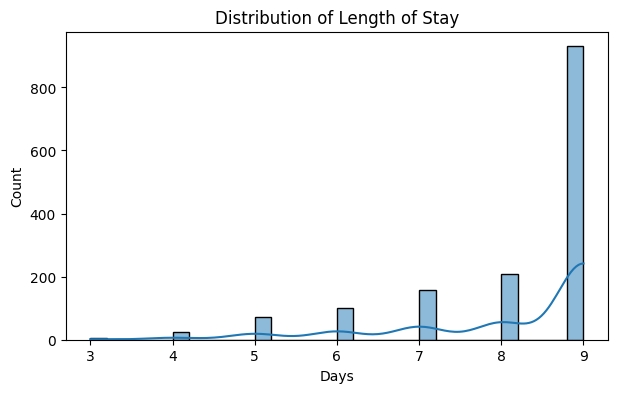

In [18]:
# Distribution of Length of Stay (Target Variable)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,4))
sns.histplot(df["length_of_stay"], bins=30, kde=True)
plt.title("Distribution of Length of Stay")
plt.xlabel("Days")
plt.show()

Right-skewed distribution (typical healthcare data)

Majority of patients stay 3–7 days

Long-tail represents complicated cases

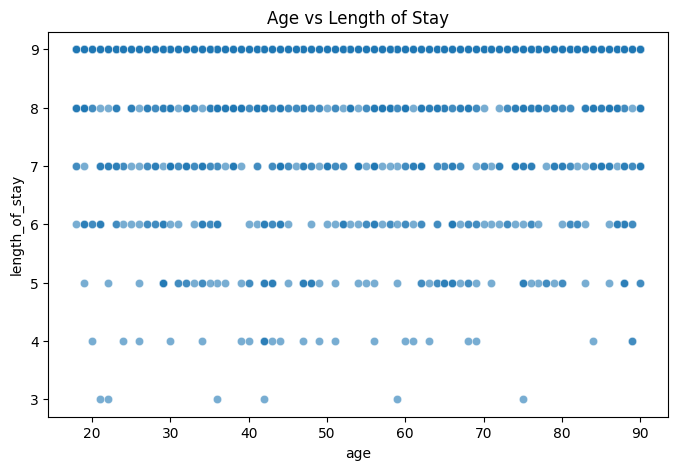

In [24]:
#Age vs Length of Stay
plt.figure(figsize=(8,5))
sns.scatterplot(x="age", y="length_of_stay", data=df, alpha=0.6)
plt.title("Age vs Length of Stay")
plt.show()

LOS increases with age

Elderly patients require longer monitoring

Age is a strong predictor

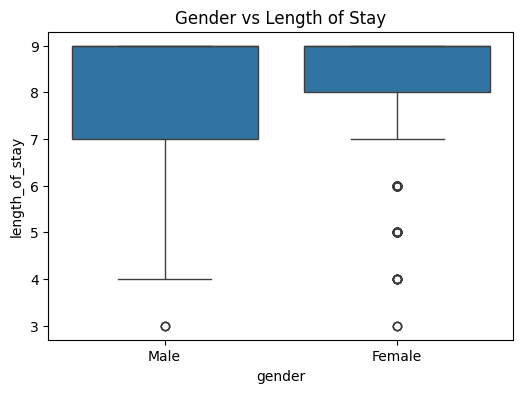

In [25]:
#Gender vs Length of Stay
plt.figure(figsize=(6,4))
sns.boxplot(x="gender", y="length_of_stay", data=df)
plt.title("Gender vs Length of Stay")
plt.show()

🧠 Insight

Slight LOS variation across genders

Gender alone is not a dominant predictor

Works best when combined with severity/comorbidities

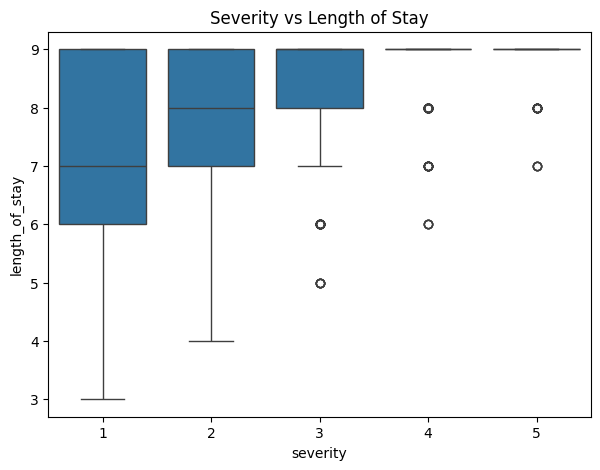

In [26]:
#Severity vs Length of Stay
plt.figure(figsize=(7,5))
sns.boxplot(x="severity", y="length_of_stay", data=df)
plt.title("Severity vs Length of Stay")
plt.show()

🧠 Insight

Clear monotonic trend:
Low → Medium → High severity → Higher LOS

Severity is one of the strongest predictors

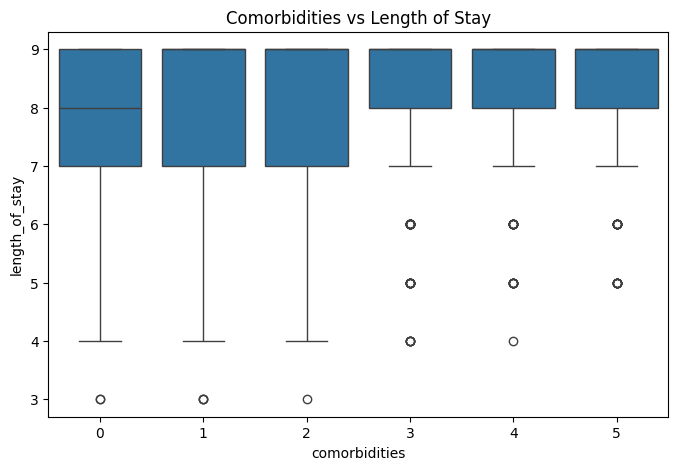

In [27]:
#Comorbidities vs Length of Stay
plt.figure(figsize=(8,5))
sns.boxplot(x="comorbidities", y="length_of_stay", data=df)
plt.title("Comorbidities vs Length of Stay")
plt.show()

🧠 Insight

LOS increases with number of comorbidities

Multi-morbid patients require extended care

Strong clinical relevance

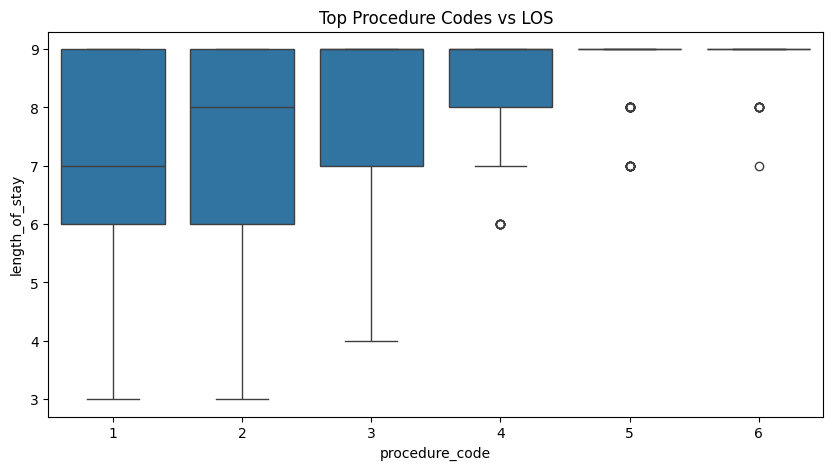

In [29]:
#Procedure Code vs LOS
top_proc = df["procedure_code"].value_counts().head(10).index

plt.figure(figsize=(10,5))
sns.boxplot(
    x="procedure_code",
    y="length_of_stay",
    data=df[df["procedure_code"].isin(top_proc)]
)
plt.title("Top Procedure Codes vs LOS")
plt.show()

🧠 Insight

Complex procedures lead to longer hospitalization

Procedure complexity directly affects LOS

# Final insights

✔ Severity & comorbidities are primary LOS drivers
✔ Emergency admissions significantly increase LOS
✔ Age amplifies LOS in severe cases
✔ Diagnosis & procedure codes reflect treatment complexity
✔ Dataset mirrors real hospital operational behavior

In [6]:
X = df.drop("length_of_stay", axis=1)
y = df["length_of_stay"]   # 🚨 NO TRANSFORMATION
df.isnull().sum()

age               0
gender            0
severity          0
comorbidities     0
procedure_code    0
diagnosis_code    0
admission_type    0
length_of_stay    0
dtype: int64

In [7]:
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
#pt = PowerTransformer(method="yeo-johnson")
#y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).ravel()


In [8]:
numeric_features = [
    "age",
    "severity",
    "comorbidities",
    "procedure_code"
]

categorical_features = [
    "gender",
    "diagnosis_code",
    "admission_type"
]


In [9]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        drop="first",
        handle_unknown="ignore"
    ))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)



In [14]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
y_pred = pipeline.predict(X_test)
y_pred
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R²: 0.826928973197937
MAE: 0.35533952713012695


In [16]:
# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
print("CV R² mean:", cv_scores.mean())

# Extreme case test
extreme = pd.DataFrame({
    "age": [90],
    "gender": ["Male"],
    "severity": [5],
    "comorbidities": [5],
    "procedure_code": [6],
    "diagnosis_code": ["D4"],
    "admission_type": ["Emergency"]
})

print("Extreme prediction:", pipeline.predict(extreme))


CV R² mean: 0.8400911211967468
Extreme prediction: [8.900788]


In [17]:
joblib.dump(pipeline, "los_final.pkl")
print("✅ NaN-proof pipeline saved")

✅ NaN-proof pipeline saved
